# AoC Day 6 Challenge. First section is grabbing the input text for the day

In [111]:
# Common Imports
import pycurl as curl
from io import BytesIO
import pandas as pd
import numpy as np
import re
import os
from functools import partial
from copy import deepcopy
from joblib import Memory
memory = Memory('/tmp/', verbose=0)
memory.clear()
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
sys.getrecursionlimit()
sys.setrecursionlimit(100_000)

[Memory(location=/tmp/joblib)]: Flushing completely the cache


In [136]:
# Get input as `input`
year = 2024
day = 6

with open('/home/alec/aoc_cookie.txt', 'r') as file:
    cookie = file.read() 

buffer = BytesIO()
c = curl.Curl()
c.setopt(curl.URL, f"https://adventofcode.com/{year}/day/{day}/input")
c.setopt(curl.COOKIE, f"session={cookie}")
c.setopt(curl.WRITEDATA, buffer)
c.perform()
c.close()

input = buffer.getvalue().decode('utf-8')

In [119]:
input = """....#.....
.........#
..........
..#.......
.......#..
..........
.#..^.....
........#.
#.........
......#..."""



# Part 1

In [137]:
entries = input.splitlines()
char_arr_orig = np.array([[c for c in entry] for entry in entries])
char_arr_shape = char_arr_orig.shape
obstacle = '#'
empty = '.'
visited = 'X'
guard_init = '^'
guard_pos = ()

def add(a,b):
    result = []
    for _a, _b in zip(a,b):
        result.append(_a+_b)
    return tuple(result)

def index(arr, v):
    return arr[v[0],v[1]]

def inbounds(bounds, pos):
    for b, p in zip(bounds, pos):
        if p < 0 or p >= b:
            return False
    return True

def setc(arr, pos, c):
    arr[pos[0],pos[1]] = c

def get_slice(arr, guard_pos, d):
    if d == 0 or d == 2:
        return arr[:, guard_pos[1]]
    else:
        return arr[guard_pos[0], :]

def get_next_obs(arr, guard_pos, d, c):
    # Get next obstacle in guards direction
    idx = [int(j) for i in np.where(arr == c) for j in i]
    if len(idx) == 0:
        return -1
    searched_idx = np.searchsorted(idx, guard_pos)
    if d > 0:
        if searched_idx >= len(idx):
            return -1
        return idx[np.searchsorted(idx, guard_pos)]
    else:
        if searched_idx == 0:
            return -1
        return idx[np.searchsorted(idx, guard_pos) - 1]

print(char_arr.shape)

(10, 10)


In [138]:
# Part 1 Attempt 2
from copy import copy
char_arr = copy(char_arr_orig)
# print(char_arr)
# Get guard start position
current_obs_pos = set()
for row , char_row in enumerate(char_arr):
    for col, c in enumerate(char_row):
        if char_arr[row, col] == guard_init:
            guard_pos = (row,col)

        if char_arr[row, col] == obstacle:
            current_obs_pos.add((row,col))
guard_pos

def follow_path_special(char_arr, guard_pos, d):
    # Define directions
    d_str = ['UP', 'RIGHT', 'DOWN', 'LEFT']
    d_unwrap = [(-1,0), (0,1), (1,0), (0,-1)]
    d_axis = [1,0,1,0]
    out_of_bounds = False
    game_steps = 0
    history = set()
    while(not out_of_bounds):

        # Advance guard
        if d_axis[d] == 1:
            col = guard_pos[1]
            obs_idx = get_next_obs(char_arr[:,col], guard_pos[0], d_unwrap[d][0], obstacle)

            adjust = -1
            if np.sum(d_unwrap[d]) < 0:
                adjust = 1
        
            if obs_idx == -1:
                out_of_bounds = True
                if adjust > 0:
                    obs_idx = -1
                else:
                    obs_idx = char_arr.shape[0]+1
                return False
            # Get guard new pos

            # Rotate
            d = (d+1) % 4 

            # Change all the symbols to visited
            char_arr[obs_idx + adjust:guard_pos[0]+adjust:adjust, col] = visited

            visited_nodes = set([(i,col,d) for i in range(obs_idx + adjust, guard_pos[0] + adjust, adjust)])
            if history.intersection(visited_nodes):
                print("TRUE")
                return True
            else:
                history.update(visited_nodes)

            # Count number of steps taken
            game_steps += np.abs(obs_idx - guard_pos[0])

            guard_pos = (obs_idx + adjust, col)

        else:
            row = guard_pos[0]
            # print(guard_pos,row, guard_pos[1])
            # print(char_arr[row,:])
            obs_idx = get_next_obs(char_arr[row,:], guard_pos[1], d_unwrap[d][1], obstacle)
            # print(obs_idx)

            adjust = -1
            if np.sum(d_unwrap[d]) < 0:
                adjust = 1

            if obs_idx == -1:
                out_of_bounds = True
                if adjust > 0:
                    obs_idx = -1
                else:
                    obs_idx = char_arr.shape[0]+1
                return False

            # Rotate
            d = (d+1) % 4 

            # Change all the symbols to visited
            char_arr[row, obs_idx + adjust:guard_pos[1]+adjust:adjust] = visited
            visited_nodes = set([(row,i,d) for i in range(obs_idx + adjust, guard_pos[1] + adjust, adjust)])
            if history.intersection(visited_nodes):
                print("TRUE")
                return True
            else:
                history.update(visited_nodes)
            # Count number of steps taken
            game_steps += np.abs(obs_idx - guard_pos[1])

            guard_pos = (row, obs_idx + adjust)

game_steps_orig, char_arr_filled = follow_path(char_arr, guard_pos, d)

char_arr_filled[guard_pos[0], guard_pos[1]] = empty

possible_obs = np.array(np.where(char_arr_filled == visited)).T
result = []
for obs_pos in tqdm(possible_obs):
    arr = copy(char_arr_orig)
    arr[obs_pos[0],obs_pos[1]] = obstacle
    if follow_path_special(arr, guard_pos, d):
        result.append(obs_pos)
    




  0%|          | 11/5211 [00:00<01:38, 52.99it/s]

TRUE
TRUE
TRUE
TRUE


  0%|          | 23/5211 [00:00<01:40, 51.66it/s]

TRUE
TRUE
TRUE
TRUE


  1%|          | 35/5211 [00:00<01:35, 54.04it/s]

TRUE
TRUE
TRUE


  1%|          | 63/5211 [00:01<01:17, 66.05it/s]

TRUE
TRUE
TRUE


  2%|▏         | 84/5211 [00:01<01:15, 67.55it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


  2%|▏         | 106/5211 [00:01<01:15, 67.34it/s]

TRUE
TRUE
TRUE
TRUE


  2%|▏         | 121/5211 [00:01<01:13, 68.92it/s]

TRUE
TRUE
TRUE
TRUE


  3%|▎         | 143/5211 [00:02<00:55, 91.66it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


  3%|▎         | 165/5211 [00:02<00:53, 94.66it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


  4%|▎         | 194/5211 [00:02<00:42, 117.05it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


  4%|▍         | 223/5211 [00:02<00:41, 121.31it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


  5%|▍         | 251/5211 [00:03<00:41, 119.83it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


  5%|▌         | 264/5211 [00:03<00:44, 111.18it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


  6%|▌         | 288/5211 [00:03<00:44, 111.62it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


  6%|▌         | 316/5211 [00:03<00:41, 119.08it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


  7%|▋         | 376/5211 [00:03<00:28, 172.24it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


  8%|▊         | 394/5211 [00:04<00:36, 130.74it/s]

TRUE
TRUE
TRUE
TRUE


  8%|▊         | 409/5211 [00:04<00:42, 112.36it/s]

TRUE
TRUE
TRUE


  8%|▊         | 435/5211 [00:04<00:42, 112.98it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


  9%|▉         | 465/5211 [00:04<00:37, 126.57it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


  9%|▉         | 494/5211 [00:04<00:36, 129.44it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 10%|▉         | 520/5211 [00:05<00:41, 112.17it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 11%|█         | 559/5211 [00:05<00:39, 118.17it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 11%|█▏        | 590/5211 [00:05<00:35, 128.47it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 12%|█▏        | 604/5211 [00:05<00:37, 123.60it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 12%|█▏        | 629/5211 [00:06<00:43, 106.39it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 13%|█▎        | 657/5211 [00:06<00:38, 119.10it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 13%|█▎        | 684/5211 [00:06<00:37, 122.29it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 14%|█▍        | 721/5211 [00:06<00:29, 150.26it/s]

TRUE
TRUE
TRUE
TRUE
TRUE


 14%|█▍        | 754/5211 [00:07<00:31, 143.60it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 15%|█▍        | 769/5211 [00:07<00:33, 131.99it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 15%|█▌        | 795/5211 [00:07<00:44, 99.57it/s] 

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 16%|█▌        | 821/5211 [00:07<00:40, 108.15it/s]

TRUE
TRUE
TRUE
TRUE
TRUE


 17%|█▋        | 868/5211 [00:08<00:36, 120.02it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 17%|█▋        | 894/5211 [00:08<00:40, 107.10it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 17%|█▋        | 906/5211 [00:08<00:47, 90.07it/s] 

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 18%|█▊        | 926/5211 [00:08<00:49, 86.80it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 18%|█▊        | 947/5211 [00:09<00:47, 88.90it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 19%|█▊        | 968/5211 [00:09<00:45, 92.46it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 19%|█▉        | 1014/5211 [00:09<00:27, 153.21it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 20%|██        | 1050/5211 [00:09<00:28, 145.98it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 21%|██        | 1080/5211 [00:10<00:32, 125.65it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 21%|██        | 1094/5211 [00:10<00:37, 108.64it/s]

TRUE
TRUE
TRUE
TRUE
TRUE


 21%|██▏       | 1117/5211 [00:10<00:44, 92.79it/s] 

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 22%|██▏       | 1152/5211 [00:10<00:41, 98.55it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 23%|██▎       | 1190/5211 [00:11<00:37, 106.86it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 23%|██▎       | 1214/5211 [00:11<00:35, 112.60it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 24%|██▍       | 1243/5211 [00:11<00:32, 122.62it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 25%|██▍       | 1278/5211 [00:11<00:27, 145.50it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 25%|██▌       | 1311/5211 [00:12<00:26, 147.16it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 26%|██▌       | 1340/5211 [00:12<00:31, 122.84it/s]

TRUE
TRUE
TRUE
TRUE


 26%|██▌       | 1366/5211 [00:12<00:33, 114.48it/s]

TRUE
TRUE
TRUE
TRUE
TRUE


 27%|██▋       | 1404/5211 [00:12<00:26, 144.61it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 28%|██▊       | 1436/5211 [00:12<00:25, 147.31it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 28%|██▊       | 1465/5211 [00:13<00:31, 119.76it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 29%|██▊       | 1491/5211 [00:13<00:34, 108.56it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 29%|██▉       | 1536/5211 [00:13<00:29, 124.65it/s]

TRUE
TRUE
TRUE


 30%|██▉       | 1558/5211 [00:13<00:24, 150.10it/s]

TRUE
TRUE
TRUE
TRUE


 31%|███       | 1590/5211 [00:14<00:26, 135.57it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 31%|███       | 1619/5211 [00:14<00:28, 124.63it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 32%|███▏      | 1645/5211 [00:14<00:29, 120.78it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 32%|███▏      | 1672/5211 [00:14<00:28, 122.30it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 33%|███▎      | 1701/5211 [00:15<00:27, 127.40it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 33%|███▎      | 1733/5211 [00:15<00:26, 129.43it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 34%|███▍      | 1760/5211 [00:15<00:29, 115.70it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 34%|███▍      | 1785/5211 [00:15<00:30, 112.43it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 34%|███▍      | 1797/5211 [00:15<00:30, 113.23it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 35%|███▍      | 1820/5211 [00:16<00:33, 102.05it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 35%|███▌      | 1841/5211 [00:16<00:36, 92.29it/s] 

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 36%|███▌      | 1861/5211 [00:16<00:38, 87.79it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 36%|███▌      | 1883/5211 [00:16<00:34, 97.19it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 37%|███▋      | 1903/5211 [00:17<00:36, 90.91it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 37%|███▋      | 1933/5211 [00:17<00:28, 116.99it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 38%|███▊      | 1959/5211 [00:17<00:30, 106.24it/s]

TRUE
TRUE
TRUE
TRUE


 38%|███▊      | 1987/5211 [00:17<00:26, 120.26it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 39%|███▉      | 2034/5211 [00:18<00:24, 127.89it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 40%|███▉      | 2074/5211 [00:18<00:20, 150.85it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 40%|████      | 2090/5211 [00:18<00:26, 117.82it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 41%|████      | 2117/5211 [00:18<00:29, 104.53it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 41%|████      | 2129/5211 [00:19<00:32, 94.79it/s] 

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 41%|████▏     | 2153/5211 [00:19<00:30, 100.58it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 42%|████▏     | 2178/5211 [00:19<00:27, 108.46it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 42%|████▏     | 2201/5211 [00:19<00:28, 104.65it/s]

TRUE
TRUE
TRUE
TRUE


 43%|████▎     | 2222/5211 [00:20<00:33, 88.33it/s] 

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 43%|████▎     | 2246/5211 [00:20<00:29, 99.57it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 44%|████▍     | 2288/5211 [00:20<00:25, 116.66it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 44%|████▍     | 2314/5211 [00:20<00:23, 121.72it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 45%|████▍     | 2341/5211 [00:21<00:25, 112.97it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 45%|████▌     | 2353/5211 [00:21<00:27, 104.76it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 46%|████▌     | 2374/5211 [00:21<00:34, 81.12it/s] 

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 46%|████▌     | 2392/5211 [00:21<00:35, 78.56it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 46%|████▌     | 2401/5211 [00:21<00:36, 77.59it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 47%|████▋     | 2434/5211 [00:22<00:27, 99.84it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 47%|████▋     | 2445/5211 [00:22<00:28, 95.63it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 47%|████▋     | 2464/5211 [00:22<00:33, 81.98it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 48%|████▊     | 2484/5211 [00:22<00:31, 86.88it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 48%|████▊     | 2519/5211 [00:23<00:26, 101.94it/s]

TRUE
TRUE
TRUE


 49%|████▉     | 2541/5211 [00:23<00:28, 94.32it/s] 

TRUE
TRUE
TRUE
TRUE
TRUE


 49%|████▉     | 2561/5211 [00:23<00:30, 88.08it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 50%|████▉     | 2584/5211 [00:23<00:26, 99.09it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 50%|█████     | 2614/5211 [00:24<00:20, 124.53it/s]

TRUE
TRUE
TRUE
TRUE


 50%|█████     | 2628/5211 [00:24<00:20, 124.97it/s]

TRUE
TRUE
TRUE
TRUE
TRUE


 51%|█████     | 2669/5211 [00:24<00:21, 118.69it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 51%|█████▏    | 2682/5211 [00:24<00:22, 112.01it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 52%|█████▏    | 2726/5211 [00:24<00:18, 136.66it/s]

TRUE
TRUE
TRUE
TRUE


 53%|█████▎    | 2758/5211 [00:25<00:17, 138.52it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 53%|█████▎    | 2773/5211 [00:25<00:18, 133.91it/s]

TRUE
TRUE
TRUE
TRUE


 54%|█████▍    | 2817/5211 [00:25<00:18, 128.23it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 55%|█████▍    | 2844/5211 [00:25<00:19, 123.83it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 55%|█████▌    | 2870/5211 [00:26<00:19, 118.04it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 56%|█████▌    | 2894/5211 [00:26<00:21, 110.09it/s]

TRUE
TRUE
TRUE


 56%|█████▌    | 2928/5211 [00:26<00:22, 100.57it/s]

TRUE
TRUE
TRUE
TRUE
TRUE


 57%|█████▋    | 2950/5211 [00:26<00:23, 96.75it/s] 

TRUE
TRUE
TRUE
TRUE


 57%|█████▋    | 2973/5211 [00:27<00:22, 99.54it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 57%|█████▋    | 2994/5211 [00:27<00:23, 93.15it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 58%|█████▊    | 3013/5211 [00:27<00:26, 81.95it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 58%|█████▊    | 3038/5211 [00:27<00:21, 100.78it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 59%|█████▉    | 3076/5211 [00:28<00:19, 110.22it/s]

TRUE
TRUE
TRUE
TRUE
TRUE


 60%|█████▉    | 3101/5211 [00:28<00:17, 117.53it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 60%|█████▉    | 3126/5211 [00:28<00:18, 110.44it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 61%|██████    | 3153/5211 [00:28<00:17, 117.95it/s]

TRUE
TRUE
TRUE


 61%|██████    | 3178/5211 [00:29<00:17, 116.19it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 61%|██████▏   | 3202/5211 [00:29<00:19, 104.09it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 62%|██████▏   | 3228/5211 [00:29<00:18, 108.60it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 62%|██████▏   | 3256/5211 [00:29<00:16, 119.54it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 63%|██████▎   | 3283/5211 [00:30<00:16, 115.28it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 63%|██████▎   | 3307/5211 [00:30<00:17, 107.34it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 64%|██████▍   | 3329/5211 [00:30<00:19, 97.61it/s] 

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 64%|██████▍   | 3354/5211 [00:30<00:17, 106.41it/s]

TRUE


 65%|██████▍   | 3365/5211 [00:30<00:17, 103.44it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 65%|██████▌   | 3390/5211 [00:31<00:16, 109.48it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 66%|██████▌   | 3430/5211 [00:31<00:14, 119.84it/s]

TRUE
TRUE
TRUE


 66%|██████▋   | 3455/5211 [00:31<00:14, 118.83it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 67%|██████▋   | 3479/5211 [00:31<00:16, 107.92it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 67%|██████▋   | 3502/5211 [00:32<00:16, 106.14it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 68%|██████▊   | 3530/5211 [00:32<00:13, 121.42it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 68%|██████▊   | 3555/5211 [00:32<00:15, 104.55it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 69%|██████▊   | 3582/5211 [00:32<00:13, 120.26it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 69%|██████▉   | 3612/5211 [00:32<00:12, 132.27it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 70%|██████▉   | 3639/5211 [00:33<00:14, 109.24it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 70%|███████   | 3651/5211 [00:33<00:14, 105.51it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 71%|███████   | 3675/5211 [00:33<00:13, 110.39it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 71%|███████▏  | 3715/5211 [00:33<00:12, 121.60it/s]

TRUE
TRUE
TRUE
TRUE
TRUE


 72%|███████▏  | 3728/5211 [00:34<00:12, 114.83it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 72%|███████▏  | 3751/5211 [00:34<00:15, 95.80it/s] 

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 72%|███████▏  | 3771/5211 [00:34<00:15, 94.27it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 73%|███████▎  | 3791/5211 [00:34<00:15, 92.51it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 73%|███████▎  | 3811/5211 [00:34<00:15, 88.84it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 73%|███████▎  | 3829/5211 [00:35<00:16, 83.45it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 74%|███████▍  | 3847/5211 [00:35<00:16, 81.25it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 75%|███████▍  | 3890/5211 [00:35<00:11, 117.51it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 75%|███████▌  | 3919/5211 [00:35<00:10, 125.43it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 76%|███████▌  | 3946/5211 [00:36<00:10, 119.97it/s]

TRUE
TRUE
TRUE


 77%|███████▋  | 3992/5211 [00:36<00:08, 137.69it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 77%|███████▋  | 4020/5211 [00:36<00:08, 132.67it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 78%|███████▊  | 4049/5211 [00:36<00:08, 130.99it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 78%|███████▊  | 4076/5211 [00:37<00:09, 118.90it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 79%|███████▊  | 4101/5211 [00:37<00:10, 110.22it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 79%|███████▉  | 4128/5211 [00:37<00:09, 120.23it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 80%|███████▉  | 4154/5211 [00:37<00:09, 116.61it/s]

TRUE
TRUE
TRUE


 80%|████████  | 4178/5211 [00:38<00:08, 116.38it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 81%|████████  | 4202/5211 [00:38<00:09, 109.28it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 82%|████████▏ | 4258/5211 [00:38<00:06, 158.32it/s]

TRUE
TRUE


 82%|████████▏ | 4275/5211 [00:38<00:06, 149.33it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 83%|████████▎ | 4305/5211 [00:39<00:06, 135.51it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 83%|████████▎ | 4348/5211 [00:39<00:07, 119.44it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 84%|████████▎ | 4361/5211 [00:39<00:07, 119.34it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 84%|████████▍ | 4388/5211 [00:39<00:07, 113.39it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 85%|████████▍ | 4424/5211 [00:40<00:07, 110.64it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 85%|████████▌ | 4448/5211 [00:40<00:06, 113.08it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 86%|████████▌ | 4471/5211 [00:40<00:06, 108.02it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 86%|████████▌ | 4493/5211 [00:40<00:07, 98.30it/s] 

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 87%|████████▋ | 4513/5211 [00:41<00:07, 94.89it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 87%|████████▋ | 4535/5211 [00:41<00:06, 101.13it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 88%|████████▊ | 4575/5211 [00:41<00:05, 120.85it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 88%|████████▊ | 4603/5211 [00:41<00:04, 128.98it/s]

TRUE
TRUE
TRUE
TRUE
TRUE


 89%|████████▉ | 4647/5211 [00:42<00:04, 132.12it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 90%|████████▉ | 4675/5211 [00:42<00:04, 127.99it/s]

TRUE
TRUE
TRUE
TRUE


 90%|█████████ | 4703/5211 [00:42<00:03, 128.09it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 91%|█████████ | 4735/5211 [00:42<00:03, 137.42it/s]

TRUE
TRUE
TRUE
TRUE


 91%|█████████▏| 4762/5211 [00:43<00:03, 113.37it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 92%|█████████▏| 4786/5211 [00:43<00:03, 109.68it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 92%|█████████▏| 4810/5211 [00:43<00:03, 108.64it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 93%|█████████▎| 4833/5211 [00:43<00:03, 109.40it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 93%|█████████▎| 4868/5211 [00:43<00:02, 138.71it/s]

TRUE
TRUE
TRUE
TRUE


 94%|█████████▍| 4896/5211 [00:44<00:02, 125.35it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 94%|█████████▍| 4922/5211 [00:44<00:02, 120.84it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 95%|█████████▍| 4947/5211 [00:44<00:02, 105.06it/s]

TRUE
TRUE
TRUE


 95%|█████████▌| 4973/5211 [00:44<00:02, 109.46it/s]

TRUE
TRUE
TRUE


 96%|█████████▌| 4996/5211 [00:45<00:02, 93.05it/s] 

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 96%|█████████▌| 5006/5211 [00:45<00:02, 88.10it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 97%|█████████▋| 5034/5211 [00:45<00:02, 80.05it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 97%|█████████▋| 5061/5211 [00:45<00:01, 105.03it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 98%|█████████▊| 5087/5211 [00:46<00:01, 114.27it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 98%|█████████▊| 5114/5211 [00:46<00:00, 119.18it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 99%|█████████▊| 5139/5211 [00:46<00:00, 114.21it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


 99%|█████████▉| 5163/5211 [00:46<00:00, 105.54it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


100%|█████████▉| 5187/5211 [00:47<00:00, 109.07it/s]

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


100%|██████████| 5211/5211 [00:47<00:00, 110.43it/s]

TRUE


In [139]:
print(len(set([(int(i[0]), int(i[1])) for i in result])))

1767


In [5]:
char_arr = np.array([[c for c in entry] for entry in entries])
# print(char_arr)
char_arr_shape = char_arr.shape
obstacle = '#'
empty = '.'
visited = 'X'
guard_init = '^'
guard_pos = ()

def add(a,b):
    result = []
    for _a, _b in zip(a,b):
        result.append(_a+_b)
    return tuple(result)

def index(arr, v):
    return arr[v[0],v[1]]

def inbounds(bounds, pos):
    for b, p in zip(bounds, pos):
        if p < 0 or p >= b:
            return False
    return True

def setc(arr, pos, c):
    arr[pos[0],pos[1]] = c

visited_dict = {}
when_visited = {}
step = 0
for row , char_row in enumerate(char_arr):
    for col, c in enumerate(char_row):
        if char_arr[row, col] == guard_init:
            guard_pos = (row,col)
guard_pos

guard_inbounds = True
d_str = ['UP', 'RIGHT', 'DOWN', 'LEFT']
d_unwrap = [(-1,0), (0,1), (1,0), (0,-1)]
d = 0
while(guard_inbounds):
    # Check infront of guard
    new_pos = add(guard_pos, d_unwrap[d])
    if not inbounds(char_arr_shape, new_pos):
        guard_inbounds = False
        setc(char_arr, guard_pos, visited)
        continue
    if index(char_arr, new_pos) == obstacle:
        # Turn right
        visited_dict.setdefault(guard_pos,[])
        visited_dict[guard_pos].append(d)
        when_visited.setdefault(guard_pos,[])
        when_visited[guard_pos].append(step)
        d = (d + 1) % 4
    else:
        # Move forward
        if new_pos == (9,6) or guard_pos == (9,6):
            print("MATCH")
        setc(char_arr, new_pos, guard_init)
        setc(char_arr, guard_pos, visited)
        visited_dict.setdefault(guard_pos,[])
        visited_dict[guard_pos].append(d)
        when_visited.setdefault(guard_pos,[])
        when_visited[guard_pos].append(step)
        step += 1
        guard_pos = new_pos
# print(char_arr)
print(np.sum(char_arr == visited))

5212


# Part 2

In [ ]:
# Part 2 Attempt 4
from copy import copy
char_arr = copy(char_arr_orig)
# print(char_arr)
# Get guard start position
current_obs_pos = set()
for row , char_row in enumerate(char_arr):
    for col, c in enumerate(char_row):
        if char_arr[row, col] == guard_init:
            guard_pos = (row,col)

        if char_arr[row, col] == obstacle:
            current_obs_pos.add((row,col))
guard_pos


# Define directions
d_str = ['UP', 'RIGHT', 'DOWN', 'LEFT']
d_unwrap = [(-1,0), (0,1), (1,0), (0,-1)]
d_axis = [1,0,1,0]
d = 0
out_of_bounds = False
game_steps = 0
while(not out_of_bounds):

    # Advance guard
    if d_axis[d] == 1:
        col = guard_pos[1]
        obs_idx = get_next_obs(char_arr[:,col], guard_pos[0], d_unwrap[d][0], obstacle)

        adjust = -1
        if np.sum(d_unwrap[d]) < 0:
            adjust = 1
    
        if obs_idx == -1:
            out_of_bounds = True
            if adjust > 0:
                obs_idx = -1
            else:
                obs_idx = char_arr.shape[0]+1
        # Get guard new pos

        # Rotate
        d = (d+1) % 4 

        # Change all the symbols to visited
        char_arr[obs_idx + adjust:guard_pos[0]+adjust:adjust, col] = visited


        # Count number of steps taken
        game_steps += np.abs(obs_idx - guard_pos[0])

        guard_pos = (obs_idx + adjust, col)

    else:
        row = guard_pos[0]
        # print(guard_pos,row, guard_pos[1])
        # print(char_arr[row,:])
        obs_idx = get_next_obs(char_arr[row,:], guard_pos[1], d_unwrap[d][1], obstacle)
        # print(obs_idx)

        adjust = -1
        if np.sum(d_unwrap[d]) < 0:
            adjust = 1

        if obs_idx == -1:
            out_of_bounds = True
            if adjust > 0:
                obs_idx = -1
            else:
                obs_idx = char_arr.shape[0]+1

        # Rotate
        d = (d+1) % 4 

        # Change all the symbols to visited
        char_arr[row, obs_idx + adjust:guard_pos[1]+adjust:adjust] = visited
        # Count number of steps taken
        game_steps += np.abs(obs_idx - guard_pos[1])

        guard_pos = (row, obs_idx + adjust)

print(f"Number of steps : {game_steps}")
img = np.where(char_arr == visited, 1, 0)
img1 = np.where(char_arr == obstacle, 10, 0)
f = plt.figure()
f.set_size_inches((10,10))
plt.imshow(img+ img1)
print(f"Number of visited squares : {np.sum(np.where(char_arr == visited, 1, 0))}")





0
1
2
3
4
5
5
6
7
8
9
9
10
11
12
13
14
14
15
16
17
18
check (5, 4) 0
19
20
20
21
22
22
23
24
25
26
26
27
28
check (6, 5) 3
29
30
30
31
32
check (6, 4) 0
33
34
check (6, 2) 0
35
35
36
36
37
38
39
40
41
check (8, 6) 2
42
42
43
check (8, 6) 3
44


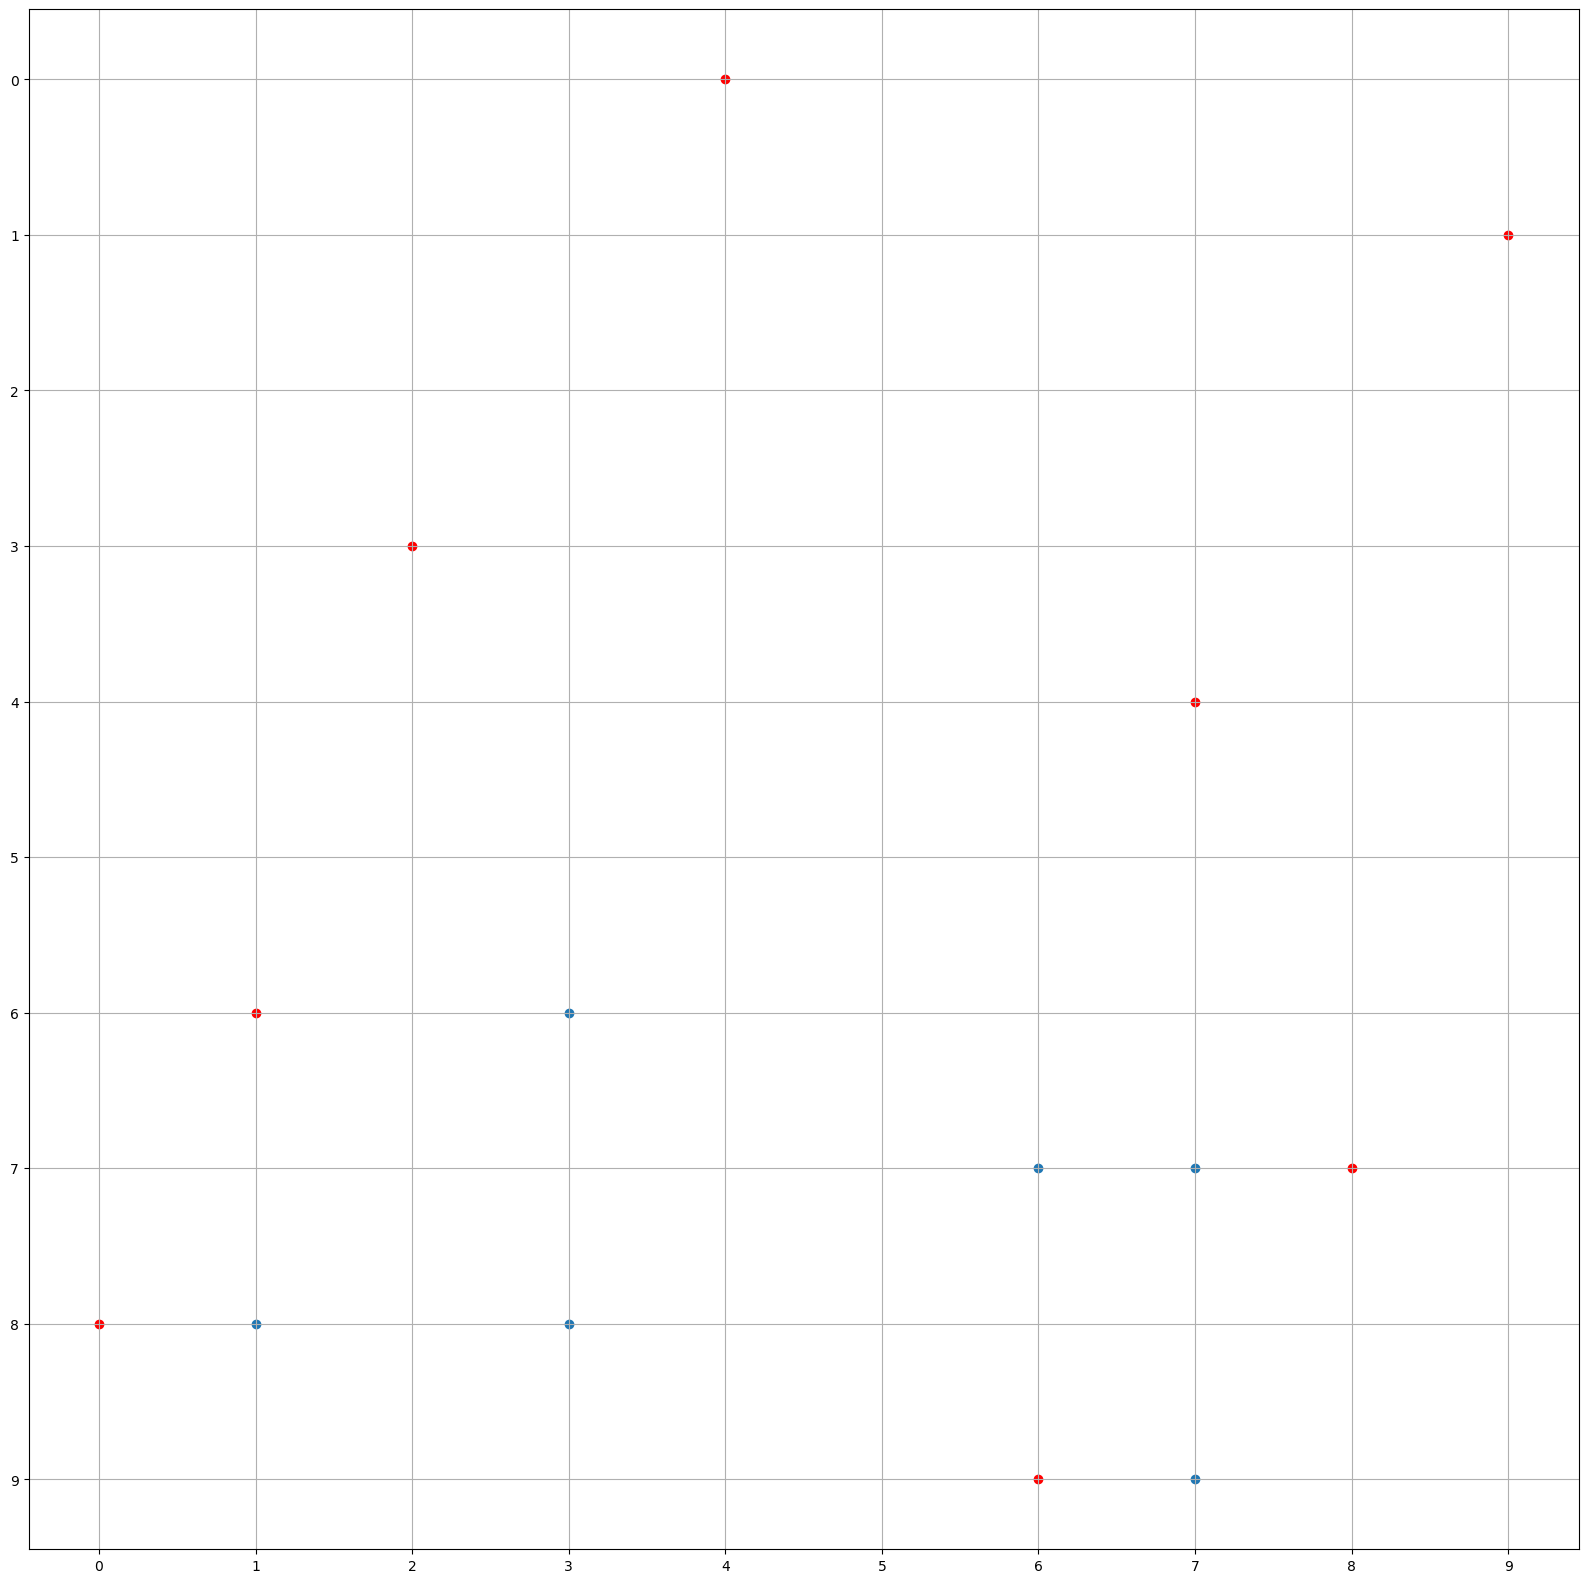

6


In [16]:
char_arr = np.array([[c for c in entry] for entry in entries])
# print(char_arr)
char_arr_shape = char_arr.shape
obstacle = '#'
empty = '.'
visited = 'X'
guard_init = '^'
guard_pos = ()

def add(a,b):
    result = []
    for _a, _b in zip(a,b):
        result.append(_a+_b)
    return tuple(result)

def index(arr, v):
    return arr[v[0],v[1]]

def inbounds(bounds, pos):
    for b, p in zip(bounds, pos):
        if p < 0 or p >= b:
            return False
    return True

def setc(arr, pos, c):
    arr[pos[0],pos[1]] = c

# Find position of important items like obstacles and guard
current_obs_pos = set()
for row , char_row in enumerate(char_arr):
    for col, c in enumerate(char_row):
        if char_arr[row, col] == guard_init:
            guard_pos = (row,col)
        if char_arr[row,col] == obstacle:
            current_obs_pos.add((row,col))
guard_start_pos = guard_pos

# Define direction for quality of life
d_str = ['UP', 'RIGHT', 'DOWN', 'LEFT']
d_unwrap = [(-1,0), (0,1), (1,0), (0,-1)]
d = 0

def follow_path_normal(arr, guard_pos, d, visited_dict, when_visited, step):
    # Advance the guard
    new_pos = add(guard_pos, d_unwrap[d])

    # Check if we should stop
    if stopping_result := not inbounds(char_arr_shape, new_pos):
        setc(arr, guard_pos, visited)
        visited_dict.setdefault(guard_pos,[])
        visited_dict[guard_pos].append(d)
        when_visited.setdefault(guard_pos,[])
        when_visited[guard_pos].append(step)
        return

    # Check if we hit an obstacle
    if index(arr, new_pos) == obstacle:
        # Turn right
        visited_dict.setdefault(guard_pos,[])
        visited_dict[guard_pos].append(d)
        when_visited.setdefault(guard_pos,[])
        when_visited[guard_pos].append(step)
        d = (d + 1) % 4
    else:
        # Move forward
        setc(arr, new_pos, guard_init)
        setc(arr, guard_pos, visited)
        visited_dict.setdefault(guard_pos,[])
        visited_dict[guard_pos].append(d)
        when_visited.setdefault(guard_pos,[])
        when_visited[guard_pos].append(step)
        step += 1
        guard_pos = new_pos
    return follow_path_normal(arr, guard_pos, d, visited_dict, when_visited, step)

def stop(pos, d):
    if not inbounds(char_arr_shape, pos):
        return 1
    if have_we_been_here_before(pos, d, visited_dict, when_visited, step):
        return 2
    return 0


def follow_path_been_here_before(arr, guard_pos, d, visited_dict, when_visited, step_origin, step, history):
    # print(f"Follow : {step} {guard_pos} {d}")
    # Advance the guard
    new_pos = add(guard_pos, d_unwrap[d])
    # print(f"Follow path : {new_pos} {d_str[d]}")

    if (new_pos, d) in history:
        # print("HISTROY : {step} {new_pos}")
        return history[(new_pos, d)]

    # Check if we should stop
    if not inbounds(arr.shape, new_pos) or have_we_been_here_before(new_pos, d, visited_dict, when_visited, step):
        # setc(arr, guard_pos, visited)
        if not inbounds(arr.shape, new_pos):
            # print(f"OUT of BOUNDS : {step} {new_pos}")
            history.setdefault((new_pos, d), False)
        else:
            # print(f"WE KNOW THIS ONE : {step} {new_pos}")
            history.setdefault((new_pos, d), True)
            # history[(new_pos,d )] = True
        return history[((new_pos, d))]

    # Check if we hit an obstacle
    if index(arr, new_pos) == obstacle:
        visited_dict.setdefault(guard_pos,[])
        visited_dict[guard_pos].append(d)
        when_visited.setdefault(guard_pos,[])
        when_visited[guard_pos].append(step)
        # Turn right
        d = (d + 1) % 4
    else:
        # Move forward
        # setc(arr, new_pos, guard_init)
        # setc(arr, guard_pos, visited)
        visited_dict.setdefault(guard_pos,[])
        visited_dict[guard_pos].append(d)
        when_visited.setdefault(guard_pos,[])
        when_visited[guard_pos].append(step)
        step += 1
        guard_pos = new_pos
    result = follow_path_been_here_before(arr, guard_pos, d, visited_dict, when_visited, step_origin, step, history)
    history.setdefault((guard_pos, d), result)
    return history[(guard_pos,d)]


def have_we_been_here_before(pos, d, visited_dict, when_visited, step):
    if pos in visited_dict and d in visited_dict[pos]:
        print("check",pos,d)
        if when_visited[pos][visited_dict[pos].index(d)] <= step:
            return True

    return False

# visited_dict = {}
# when_visited = {}
# step = 0
# follow_path_normal(char_arr, guard_pos, d, visited_dict, when_visited, step)
# print(len(visited_dict))
# print(np.sum(char_arr == visited))


def follow_path_special(arr, guard_pos, d, visited_dict, when_visited, step, obs_pos, potential_spots):
    print(step)

    # Advance the guard
    new_pos = add(guard_pos, d_unwrap[d])

    # Check if the new_position could be an obstacle
    new_obs_pos = new_pos
    new_guard_d = (d+1)%4
    history = {}
    if follow_path_been_here_before(arr, guard_pos, new_guard_d, deepcopy(visited_dict), deepcopy(when_visited), step, step, history):
        # print(guard_pos, new_pos, d_str[d], d_str[new_guard_d])
        # print(history)
        # print(visited_dict)
        # print(when_visited)
        obs_pos.append(new_obs_pos)

    # Check if we should stop
    if not inbounds(arr.shape, new_pos):
        # setc(arr, guard_pos, visited)
        return

    # Check if we hit an obstacle
    if index(arr, new_pos) == obstacle:
        # Turn right
        visited_dict.setdefault(guard_pos,[])
        visited_dict[guard_pos].append(d)
        when_visited.setdefault(guard_pos,[])
        when_visited[guard_pos].append(step)
        
        d = (d + 1) % 4
    else:
        # Move forward
        # setc(arr, new_pos, guard_init)
        # setc(arr, guard_pos, visited)
        visited_dict.setdefault(guard_pos,[])
        visited_dict[guard_pos].append(d)
        when_visited.setdefault(guard_pos,[])
        when_visited[guard_pos].append(step)
        step += 1
        guard_pos = new_pos

    # if len(obs_pos) > 2:
    #     return
    return follow_path_special(arr, guard_pos, d, visited_dict, when_visited, step, obs_pos)

obs_pos = []
step = 0
new_visited_dict = {}
new_when_visited = {}
potential_spots = {}
follow_path_special(char_arr, guard_start_pos, d, new_visited_dict, new_when_visited, step, obs_pos, potential_spots)
# print(obs_pos)
new_obs_pos = set(obs_pos).difference(current_obs_pos)
new_obs_pos = new_obs_pos.difference(set(guard_start_pos))
obs_np = np.array(obs_pos)
fig = plt.gcf()
fig.set_size_inches((20,20))
plt.scatter(obs_np[:,1], obs_np[:,0])
obs_np = np.array(list(current_obs_pos))
plt.scatter(obs_np[:,1], obs_np[:,0], c='r')
plt.gca().invert_yaxis()
plt.grid()
plt.yticks(list(range(char_arr.shape[0])))
plt.xticks(list(range(char_arr.shape[0])))
plt.show()
# plt.yticks(list(range(9,-1,-1)))
print(len(new_obs_pos))

# Notes:

# Steps are different between the OG path and the new path.
# Sort what visited places are allows from OG places and give them like a -1 number

In [10]:
pos_arr = np.array(list(new_obs_pos))
print(np.sum(pos_arr < 0))

0


In [ ]:
char_arr = np.array([[c for c in entry] for entry in entries])
# print(char_arr)
char_arr_shape = char_arr.shape
obstacle = '#'
empty = '.'
visited = 'X'
guard_init = '^'
guard_pos = ()

def add(a,b):
    result = []
    for _a, _b in zip(a,b):
        result.append(_a+_b)
    return tuple(result)

def index(arr, v):
    return arr[v[0],v[1]]

def inbounds(bounds, pos):
    for b, p in zip(bounds, pos):
        if p < 0 or p >= b:
            return False
    return True

def setc(arr, pos, c):
    arr[pos[0],pos[1]] = c

# Find position of important items like obstacles and guard
current_obs_pos = set()
for row , char_row in enumerate(char_arr):
    for col, c in enumerate(char_row):
        if char_arr[row, col] == guard_init:
            guard_pos = (row,col)
        if char_arr[row,col] == obstacle:
            current_obs_pos.add((row,col))
guard_start_pos = guard_pos

# Define direction for quality of life
d_str = ['UP', 'RIGHT', 'DOWN', 'LEFT']
d_unwrap = [(-1,0), (0,1), (1,0), (0,-1)]
d = 0

def follow_path_normal(arr, guard_pos, d):
    d_str = ['UP', 'RIGHT', 'DOWN', 'LEFT']
    d_unwrap = [(-1,0), (0,1), (1,0), (0,-1)]
    # some metric to track
    visited_dict = {}
    when_visited = {}
    step = 0
    while(1):
        # Advance the guard
        new_pos = add(guard_pos, d_unwrap[d])

        # Check if we should stop
        if stopping_result := not inbounds(char_arr_shape, new_pos):
            setc(arr, guard_pos, visited)
            visited_dict.setdefault(guard_pos,[])
            visited_dict[guard_pos].append(d)
            when_visited.setdefault(guard_pos,[])
            when_visited[guard_pos].append(step)
            break

        # Check if we hit an obstacle
        if index(arr, new_pos) == obstacle:
            # Turn right
            visited_dict.setdefault(guard_pos,[])
            visited_dict[guard_pos].append(d)
            when_visited.setdefault(guard_pos,[])
            when_visited[guard_pos].append(step)
            d = (d + 1) % 4
        else:
            # Move forward
            setc(arr, new_pos, guard_init)
            setc(arr, guard_pos, visited)
            visited_dict.setdefault(guard_pos,[])
            visited_dict[guard_pos].append(d)
            when_visited.setdefault(guard_pos,[])
            when_visited[guard_pos].append(step)
            step += 1
            guard_pos = new_pos
    return visited_dict, when_visited, stopping_result

def stop(pos, d):
    if not inbounds(char_arr_shape, pos):
        return 1
    if have_we_been_here_before(pos, d, visited_dict, when_visited, step):
        return 2
    return 0

@memory.cache
def follow_path_been_here_before(arr, guard_pos, d, visited_dict, when_visited, step):
    d_str = ['UP', 'RIGHT', 'DOWN', 'LEFT']
    d_unwrap = [(-1,0), (0,1), (1,0), (0,-1)]
    # some metric to track

    while(1):
        # Advance the guard
        new_pos = add(guard_pos, d_unwrap[d])

        # Check if we should stop
        
        if not inbounds(arr.shape, new_pos) or have_we_been_here_before(new_pos, d, visited_dict, when_visited, step) :
            # setc(arr, guard_pos, visited)
            if not inbounds(arr.shape, new_pos):
                stopping_result = 1
            else:
                stopping_result = 2
            break

        # Check if we hit an obstacle
        if index(arr, new_pos) == obstacle:
            # Turn right
            d = (d + 1) % 4
        else:
            # Move forward
            # setc(arr, new_pos, guard_init)
            # setc(arr, guard_pos, visited)
            step += 1
            guard_pos = new_pos
    return visited_dict, when_visited, stopping_result


def have_we_been_here_before(pos, d, visited_dict, when_visited, step):
    if pos in visited_dict and d in visited_dict[pos]:
            # if when_visited[pos][visited_dict[pos].index(d)] <= step:
            return True

    return False

@memory.cache
def will_we_be_where_weve_been(arr, pos, d, visited_dict, when_visited, step):
    # # we are where we are, move us in d
    # next_pos = add(pos, d)

    # Check if we are out-of-bounds, or if this is an obstacle
    # follow path if it is an obstacle unit you are out-of-bounds or hit where we have been
    def stop(pos, d):
        if not inbounds(char_arr_shape, pos):
            return 1
        if have_we_been_here_before(pos, d, visited_dict, when_visited, step):
            return 2
        return 0
        
    _visited_dict, _when_visited, result = follow_path_been_here_before(arr, pos, d, visited_dict, when_visited, step)
    if result == 2:
        return True
    return False

visited_dict, when_visited, result = follow_path_normal(char_arr, guard_pos, d)
print(len(visited_dict))
print(np.sum(char_arr == visited))

def follow_path_special(arr, guard_pos, d, stop_criteria, visited_dict, when_visited):
    d_str = ['UP', 'RIGHT', 'DOWN', 'LEFT']
    d_unwrap = [(-1,0), (0,1), (1,0), (0,-1)]
    # some metric to track

    obs_pos = []
    step = 0
    while(1):
        print(step)

        # Advance the guard
        new_pos = add(guard_pos, d_unwrap[d])

        # Check if the new_position could be an obstacle
        new_obs_pos = new_pos
        new_guard_d = (d+1)%4

        if will_we_be_where_weve_been(arr, guard_pos, new_guard_d, visited_dict, when_visited, step):
            obs_pos.append(new_obs_pos)

        # Check if we should stop
        if stopping_result := stop_criteria(new_pos,d):
            # setc(arr, guard_pos, visited)
            break

        # Check if we hit an obstacle
        if index(arr, new_pos) == obstacle:
            # Turn right
            d = (d + 1) % 4
        else:
            # Move forward
            # setc(arr, new_pos, guard_init)
            # setc(arr, guard_pos, visited)
            step += 1
            guard_pos = new_pos
    return obs_pos # The answer


obs_pos = follow_path_special(char_arr, guard_pos, d, lambda x,y : not partial(inbounds, char_arr_shape)(x), visited_dict, when_visited)
print(len(set(obs_pos)))
print(obs_pos)
# total = 0
# obs_pos = []
# step = 0
# while(guard_inbounds):
#     # Check around the guard to see if we can enter any visited paths 
#     # (check if we turn right we visit the same path in the same direction)
#     check_dir = (d+1)%4
#     check_pos = add(guard_pos, d_unwrap[check_dir])
#     # if inbounds(char_arr_shape, check_pos):
#     #     if index(char_arr, check_pos) in ['0','1','2','3'] and index(char_arr, check_pos) == check_dir and check_pos != guard_start_pos:
#     #         total += 1
#     # Check if we have been this direction before like ever
#     avoid_checking_more = False
#     if check_pos in visited_dict:
#         if check_dir in visited_dict[check_pos]  and add(guard_pos, d_unwrap[d]) != guard_start_pos:
#             if when_visited[check_pos][visited_dict[check_pos].index(check_dir)] <= step:
#                 _obs_pos = add(guard_pos, d_unwrap[d])
#                 if _obs_pos not in obs_pos and _obs_pos not in current_obs_pos:
#                     total += 1
#                     obs_pos.append(_obs_pos)
#                 avoid_checking_more = True
#     if index(char_arr,check_pos) == obstacle:
#         avoid_checking_more = False
#     check_pos = add(check_pos, d_unwrap[check_dir])
#     if not avoid_checking_more:
#         checking_valid = True
#         while(checking_valid):
#             if inbounds(char_arr_shape, check_pos) and index(char_arr, check_pos) != obstacle:
#                 if check_pos in visited_dict:
#                     if check_dir in visited_dict[check_pos] and when_visited[check_pos][visited_dict[check_pos].index(check_dir)] >= step:
#                         _obs_pos = add(guard_pos, d_unwrap[d])
#                         if _obs_pos not in obs_pos and _obs_pos not in current_obs_pos:
#                             total += 1
#                             obs_pos.append(_obs_pos)
#                         checking_valid = False
#                         break
                
#                 check_pos = add(check_pos, d_unwrap[check_dir])
#             else:
#                 checking_valid = False

#     # Check infront of guard
#     new_pos = add(guard_pos, d_unwrap[d])
#     if not inbounds(char_arr_shape, new_pos):
#         guard_inbounds = False
#         setc(char_arr, guard_pos, visited)
#         continue
#     if index(char_arr, new_pos) == obstacle:
#         # Turn right
#         d = (d + 1) % 4
#     else:
#         # Move forward
#         setc(char_arr, new_pos, guard_init)
#         setc(char_arr, guard_pos, visited)


#         guard_pos = new_pos
#         step+= 1
# # print(char_arr)
# print(total)
# for p in obs_pos:
#     c = index(char_arr, p)
#     setc(char_arr,p, '0')
#     print(char_arr)
#     setc(char_arr,p, c)

In [ ]:
char_arr = np.array([[c for c in entry] for entry in entries])
# print(char_arr)
char_arr_shape = char_arr.shape
obstacle = '#'
empty = '.'
visited = 'X'
guard_init = '^'
guard_pos = ()

def add(a,b):
    result = []
    for _a, _b in zip(a,b):
        result.append(_a+_b)
    return tuple(result)

def index(arr, v):
    return arr[v[0],v[1]]

def inbounds(bounds, pos):
    for b, p in zip(bounds, pos):
        if p < 0 or p >= b:
            return False
    return True

def setc(arr, pos, c):
    arr[pos[0],pos[1]] = c

current_obs_pos = set()
for row , char_row in enumerate(char_arr):
    for col, c in enumerate(char_row):
        if char_arr[row, col] == guard_init:
            guard_pos = (row,col)
        if char_arr[row,col] == obstacle:
            current_obs_pos.add((row,col))
guard_start_pos = guard_pos

# print(current_obs_pos)

guard_inbounds = True
d_str = ['UP', 'RIGHT', 'DOWN', 'LEFT']
d_unwrap = [(-1,0), (0,1), (1,0), (0,-1)]
d = 0
total = 0
# visited_dict = {}
# when_visited = {}
obs_pos = []
step = 0
while(guard_inbounds):
    # Check around the guard to see if we can enter any visited paths 
    # (check if we turn right we visit the same path in the same direction)
    check_dir = (d+1)%4
    check_pos = add(guard_pos, d_unwrap[check_dir])
    # if inbounds(char_arr_shape, check_pos):
    #     if index(char_arr, check_pos) in ['0','1','2','3'] and index(char_arr, check_pos) == check_dir and check_pos != guard_start_pos:
    #         total += 1
    # Check if we have been this direction before like ever
    avoid_checking_more = False
    if check_pos in visited_dict:
        if check_dir in visited_dict[check_pos]  and add(guard_pos, d_unwrap[d]) != guard_start_pos:
            if when_visited[check_pos][visited_dict[check_pos].index(check_dir)] <= step:
                _obs_pos = add(guard_pos, d_unwrap[d])
                if _obs_pos not in obs_pos and _obs_pos not in current_obs_pos:
                    total += 1
                    obs_pos.append(_obs_pos)
                avoid_checking_more = True
    if index(char_arr,check_pos) == obstacle:
        avoid_checking_more = False
    check_pos = add(check_pos, d_unwrap[check_dir])
    if not avoid_checking_more:
        checking_valid = True
        while(checking_valid):
            if inbounds(char_arr_shape, check_pos) and index(char_arr, check_pos) != obstacle:
                if check_pos in visited_dict:
                    if check_dir in visited_dict[check_pos] and when_visited[check_pos][visited_dict[check_pos].index(check_dir)] >= step:
                        _obs_pos = add(guard_pos, d_unwrap[d])
                        if _obs_pos not in obs_pos and _obs_pos not in current_obs_pos:
                            total += 1
                            obs_pos.append(_obs_pos)
                        checking_valid = False
                        break
                
                check_pos = add(check_pos, d_unwrap[check_dir])
            else:
                checking_valid = False

    # Check infront of guard
    new_pos = add(guard_pos, d_unwrap[d])
    if not inbounds(char_arr_shape, new_pos):
        guard_inbounds = False
        setc(char_arr, guard_pos, visited)
        continue
    if index(char_arr, new_pos) == obstacle:
        # Turn right
        d = (d + 1) % 4
    else:
        # Move forward
        setc(char_arr, new_pos, guard_init)
        setc(char_arr, guard_pos, visited)


        guard_pos = new_pos
        step+= 1
# print(char_arr)
print(total)
for p in obs_pos:
    c = index(char_arr, p)
    setc(char_arr,p, '0')
    print(char_arr)
    setc(char_arr,p, c)